In [ ]:
pip install aif360 fairlearn smclarify

In [ ]:
import pandas as pd 
import numpy as np
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from smclarify.bias import report
import seaborn as sns
import io
import base64
import IPython

In [ ]:
df = pd.read_csv("https://qusandbox-dataset.s3.us-west-2.amazonaws.com/LendingClubLoan.csv")
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
0,5000,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,11-Dec,credit_card,AZ,27.65,0,1,0
1,2500,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,11-Dec,car,GA,1.00,0,5,1
2,2400,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,11-Dec,small_business,IL,8.72,0,2,0
3,10000,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,11-Dec,other,CA,20.00,0,1,0
4,3000,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,11-Dec,other,OR,17.94,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,10000,60 months,12.99,227.48,C,C1,3 years,RENT,50000.0,Source Verified,11-Aug,small_business,CA,11.66,0,0,0
9995,5000,36 months,13.49,169.66,C,C2,10+ years,MORTGAGE,113000.0,Source Verified,11-Aug,wedding,FL,12.96,0,0,0
9996,14975,60 months,13.49,344.50,C,C2,3 years,RENT,49100.0,Source Verified,11-Aug,debt_consolidation,CA,15.71,0,1,0
9997,3600,36 months,15.62,125.90,D,D1,2 years,RENT,132000.0,Not Verified,11-Aug,other,NY,21.62,2,0,0


In [ ]:
emp_length_values = df.emp_length.unique()
def privileged_function(year_string):
  if not isinstance(year_string, str):
    return True
  elif '+' in year_string:
    return False
  elif '<' in year_string:
    return True
  elif int(year_string[0]) <= 1:
    return True
  else:
    return False
emp_length_values

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [ ]:
dataset_orig = StandardDataset(df, 
                          label_name='loan_status_Binary', 
                          favorable_classes=[1], 
                          protected_attribute_names=['emp_length'], 
                          privileged_classes=[privileged_function],
                          categorical_features=['term','grade','sub_grade','home_ownership','verification_status','issue_d','purpose','addr_state'])
privileged_groups = [{'emp_length': 1}]
unprivileged_groups = [{'emp_length': 0}]

In [ ]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.014731


In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

In [ ]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [ ]:
smc_df = df.copy()
def emp_modifier(year_string):
  if not isinstance(year_string, str):
    return 'short'
  elif '+' in year_string:
    return 'long'
  elif '<' in year_string:
    return 'short'
  elif int(year_string[0]) <= 2:
    return 'short'
  elif int(year_string[0]) <= 8:
    return 'middle'
  else:
    return 'long'
smc_df['emp_length'] = smc_df['emp_length'].apply(emp_modifier)
smc_df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
0,5000,36 months,10.65,162.87,B,B2,long,RENT,24000.0,Verified,11-Dec,credit_card,AZ,27.65,0,1,0
1,2500,60 months,15.27,59.83,C,C4,short,RENT,30000.0,Source Verified,11-Dec,car,GA,1.00,0,5,1
2,2400,36 months,15.96,84.33,C,C5,long,RENT,12252.0,Not Verified,11-Dec,small_business,IL,8.72,0,2,0
3,10000,36 months,13.49,339.31,C,C1,long,RENT,49200.0,Source Verified,11-Dec,other,CA,20.00,0,1,0
4,3000,60 months,12.69,67.79,B,B5,short,RENT,80000.0,Source Verified,11-Dec,other,OR,17.94,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,10000,60 months,12.99,227.48,C,C1,middle,RENT,50000.0,Source Verified,11-Aug,small_business,CA,11.66,0,0,0
9995,5000,36 months,13.49,169.66,C,C2,long,MORTGAGE,113000.0,Source Verified,11-Aug,wedding,FL,12.96,0,0,0
9996,14975,60 months,13.49,344.50,C,C2,middle,RENT,49100.0,Source Verified,11-Aug,debt_consolidation,CA,15.71,0,1,0
9997,3600,36 months,15.62,125.90,D,D1,short,RENT,132000.0,Not Verified,11-Aug,other,NY,21.62,2,0,0


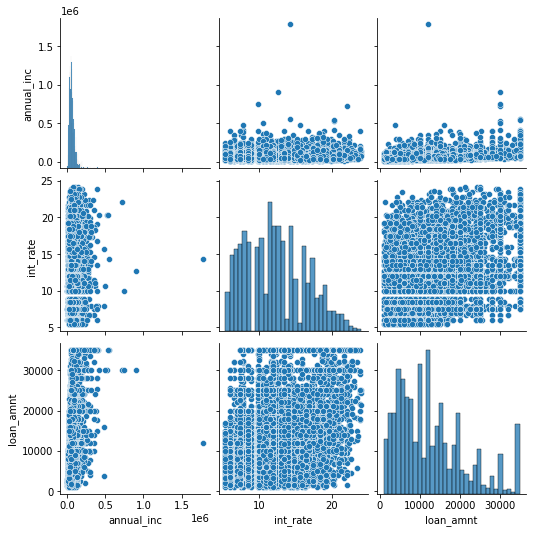

In [ ]:
pair_pic = sns.pairplot(smc_df[['annual_inc', 'int_rate', 'loan_amnt']])
pic_IObytes = io.BytesIO()
pair_pic.savefig(pic_IObytes,  format='png')
pic_IObytes.seek(0)
pair_pic_hash = base64.b64encode(pic_IObytes.read())

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


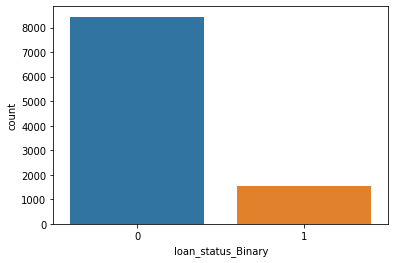

In [ ]:
count_ax = sns.countplot(smc_df['loan_status_Binary'])
pic_IObytes = io.BytesIO()
count_ax.figure.savefig(pic_IObytes,  format='png')
pic_IObytes.seek(0)
count_pic_hash = base64.b64encode(pic_IObytes.read())

In [ ]:
facet_column = report.FacetColumn('emp_length')
label_column = report.LabelColumn(name='loan_status_Binary', data=smc_df['loan_status_Binary'], positive_label_values=[1])
group_variable = smc_df["term"]

In [ ]:
report_bias = report.bias_report(smc_df, facet_column, label_column, stage_type=report.StageType.PRE_TRAINING, group_variable=group_variable)
report_bias

[{'metrics': [{'description': 'Conditional Demographic Disparity in Labels (CDDL)',
    'name': 'CDDL',
    'value': 0.02264726754881497},
   {'description': 'Class Imbalance (CI)',
    'name': 'CI',
    'value': 0.43154315431543155},
   {'description': 'Difference in Positive Proportions in Labels (DPL)',
    'name': 'DPL',
    'value': -0.004296763344538407},
   {'description': 'Jensen-Shannon Divergence (JS)',
    'name': 'JS',
    'value': 1.7478677791710586e-05},
   {'description': 'Kullback-Liebler Divergence (KL)',
    'name': 'KL',
    'value': 6.965607609347047e-05},
   {'description': 'Kolmogorov-Smirnov Distance (KS)',
    'name': 'KS',
    'value': 0.0042967633445384346},
   {'description': 'L-p Norm (LP)',
    'name': 'LP',
    'value': 0.006076540996153815},
   {'description': 'Total Variation Distance (TVD)',
    'name': 'TVD',
    'value': 0.004296763344538421}],
  'value_or_threshold': 'long'},
 {'metrics': [{'description': 'Conditional Demographic Disparity in Labels 

In [ ]:
import requests
import json
from types import SimpleNamespace

# prod server
SERVER_URL = "https://api.quantuniversity.com"

class ReportGenerator:
    def __init__(self, name="test", version="1.0", category="basic", notes=[]):
        self.name = name
        self.version = version
        self.category = category
        self.detail = {}
        self.notes = []
        for note in notes:
            self.notes.append(note.__dict__)
        
    def load(self, value={}):
        if isinstance(value, (dict, str)):
            self.detail = value
        else:
            # self.detail = json.loads(json.dumps(value, default=lambda o: o.__dict__))
            self.detail = value.value
            
    def add_note(self, note):
        self.notes.append(note.__dict__)
    
    def generate(self):
        url = SERVER_URL + "/experiment/public/stage/" + self.category + "/artifact/"
        body = {
            "report_parameters": {
                "name": self.name,
                "version": self.version
            },
            "report_details": self.detail,
            "notes": self.notes
        }
        print(json.dumps(body, indent=4, sort_keys=True))
        response = requests.post(url, json.dumps(body))
        if response.status_code != 200:
            raise ValueError('Unexpected happened.')
        self.report = response.json()['HTML']
        return self.report
    
    def save(self, path="audit.html"):
        file = open(path, "w")
        file.write(self.report)
        print("report is saved to " + file.name)
        file.close()
        try:
            from google.colab import files
            files.download(path)
        except:
            pass
    
    def publish(self, APIkey="", experiment="", stage=""):
        print("Publish reports to QuSandbox available with prime version, contact info@qusandbox.com for more infomation")
    
    
class TemplateReader:
    def __init__(self, template_id="7acd5c69079946b199c8bab692512f27"):
        self.template_id = template_id
        
    def load(self):
        url = SERVER_URL + "/template/" + self.template_id
        response = requests.get(url)
        self.template = response.json()['Items'][0]
        
    def get_raw_json(self):
        return json.loads(self.template['templateValue'])
    
    def get_sample_input(self):
        survey_json = json.loads(self.template['templateValue'])
        sample_input = {}
        for page in survey_json['pages']:
            for element in page['elements']:
                if element['type'] == 'panel':
                    for question in element['elements']:
                        if question["type"] == "rating":
                            sample_input[question['name']] = 4
                        elif question["type"] == "text":
                            sample_input[question['name']] = question['defaultValue']
                        else:
                            sample_input[question['name']] = "TBD"
                else:
                    sample_input[element['name']] = "TBD"
        # return json.loads(json.dumps(sample_input), object_hook=lambda d: SimpleNamespace(**d))
        return TemplateValue(sample_input)
    
class Note:
    categories = ['plotly_json', 'plotly_chart', 'embed', 'link', 'base64', 'file']
    def __init__(self, category="base64", value="", title="", description=""):
        self.Title = title
        self.Content = description
        if category not in self.categories:
            print('Support categories are ' + str(self.categories))
            raise ValueError('Not a support note category')
        else:
            if category in ['link', 'base64', 'file']:
                self.ArtifactType = 'base64'
                if category == 'file':
                    import base64
                    data = open(value, "r").read()
                    self.Artifact = "data:image/jpeg;base64," + base64.b64encode(data).decode('utf-8')
                else:
                    self.Artifact = "data:image/jpeg;base64," + value.decode('utf-8')
            elif category == 'embed':
                self.ArtifactType = 'embed'
                self.Artifact = value
            elif category in ['plotly_json', 'plotly_chart']:
                import plotly
                self.ArtifactType = 'plotly'
                if category == 'plotly_chart':
                    self.Artifact = plotly.io.to_json(value)
                else:
                    self.Artifact = value

class TemplateValue:
    def __init__(self, input={}):
        self.value = input

    def set_value(self, key, value):
        self.value[key] = value

    def delete_value(self, key):
        if key in self.value:
          del self.value[key]

    def __repr__(self):
        return json.dumps(self.value)

    def __str__(self):
        return json.dumps(self.value)

def browse_all_templates():
    url = SERVER_URL + "/template/"
    response = requests.get(url)
    results = response.json()['Items']
    templates = []
    for result in results:
        templates.append({
            "id":result["SK"].split('#')[1],
            "name":result["templateName"],
            "sample":result["templateSample"],
            "category":result["templateType"]
        })
    return templates

def get_sample(url):
    return requests.get(url).text

def show_report(html):
    try:
        from IPython.core.display import HTML
        display(HTML(html))
    except:
        print('Not in notebook environment, please copy the html string to a file manually')

In [ ]:
test_input = TemplateValue()
test_input.set_value('Compute fairness metric using AIF360', 
                     'Considering employed years shorter than 3 years as privileged groups, loan approved status as label. Difference in mean outcomes between unprivileged and privileged groups = -0.014731')
test_input.set_value('Compute fairness metric using smclarify', 
                     'Considering employer years shorter than 3 years, between 3 and 8 years, longer than 8 years as different groups. Calculated metrics attached as appendix.')

In [ ]:
note_pair = Note(category='base64', 
                title='Pair graph',
                value=pair_pic_hash)
note_count = Note(category='base64',  
                  title='Count graph',
                  value=count_pic_hash)

In [ ]:
report_df = pd.DataFrame(columns=['Threshold', 'CDDL', 'CI', 'DPL', 'JS', 'KL','KS', 'LP', 'TVD'])
for i in range(len(report_bias)):
  report_df.at[i, 'Threshold'] = report_bias[i]['value_or_threshold']
  for j in range(len(report_bias[i]['metrics'])):
    report_df.at[i, report_bias[i]['metrics'][j]['name']] = report_bias[i]['metrics'][j]['value']
html = report_df.to_html(escape=False, index=False)
html_center = html.replace('<td>', '<td style="text-align:center">').replace('<th>', '<th style="text-align:center">')
IPython.display.HTML(html_center)

Threshold,CDDL,CI,DPL,JS,KL,KS,LP,TVD
long,0.0226473,0.431543,-0.00429676,1.74787e-05,6.96561e-05,0.00429676,0.00607654,0.00429676
short,-0.0367559,0.409541,-0.00847057,6.76496e-05,0.000268651,0.00847057,0.0119792,0.00847057
middle,0.0141086,0.158916,0.0108197,0.000111888,0.000451893,0.0108197,0.0153013,0.0108197


In [ ]:
note_embed = Note(category='embed',
                  title='Smclarify Metrics', 
                  value=html_center)

{
    "notes": [
        {
            "Artifact": "<table border=\"1\" class=\"dataframe\">\n  <thead>\n    <tr style=\"text-align: right;\">\n      <th style=\"text-align:center\">Threshold</th>\n      <th style=\"text-align:center\">CDDL</th>\n      <th style=\"text-align:center\">CI</th>\n      <th style=\"text-align:center\">DPL</th>\n      <th style=\"text-align:center\">JS</th>\n      <th style=\"text-align:center\">KL</th>\n      <th style=\"text-align:center\">KS</th>\n      <th style=\"text-align:center\">LP</th>\n      <th style=\"text-align:center\">TVD</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td style=\"text-align:center\">long</td>\n      <td style=\"text-align:center\">0.0226473</td>\n      <td style=\"text-align:center\">0.431543</td>\n      <td style=\"text-align:center\">-0.00429676</td>\n      <td style=\"text-align:center\">1.74787e-05</td>\n      <td style=\"text-align:center\">6.96561e-05</td>\n      <td style=\"text-align:center\">0.00429676</td>\
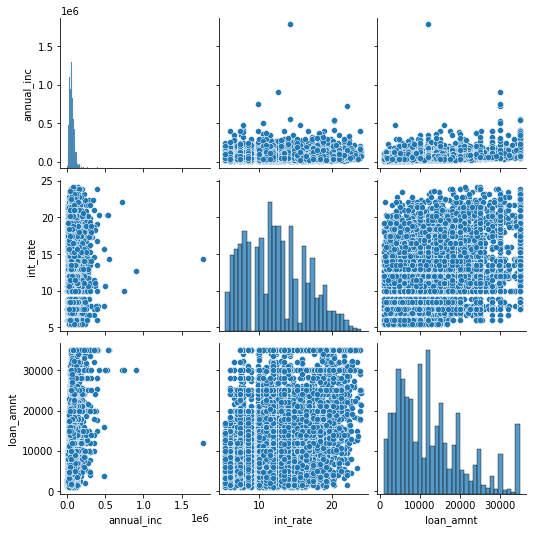
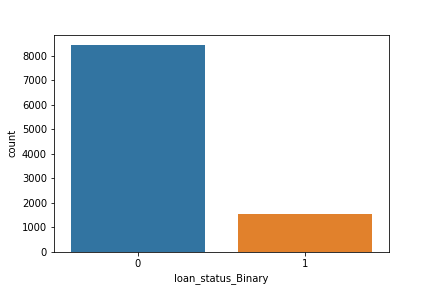

Threshold,CDDL,CI,DPL,JS,KL,KS,LP,TVD
long,0.0226473,0.431543,-0.00429676,1.74787e-05,6.96561e-05,0.00429676,0.00607654,0.00429676
short,-0.0367559,0.409541,-0.00847057,6.76496e-05,0.000268651,0.00847057,0.0119792,0.00847057
middle,0.0141086,0.158916,0.0108197,0.000111888,0.000451893,0.0108197,0.0153013,0.0108197

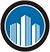
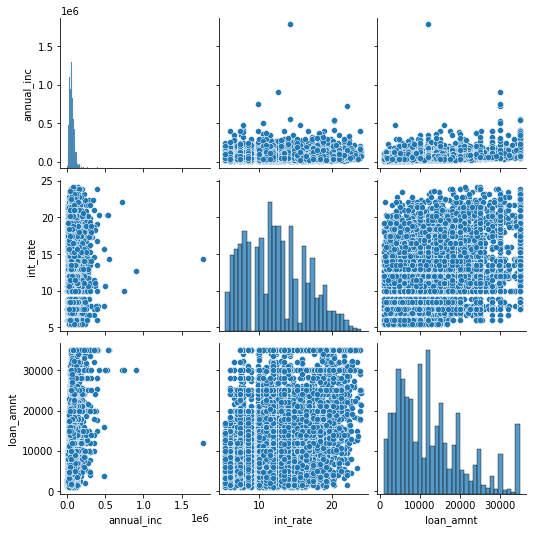
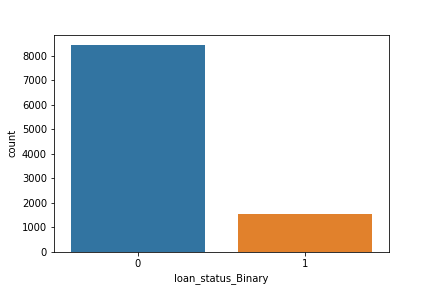

In [ ]:
# generate new report
MyReportGenerator = ReportGenerator(name="Credit Risk Fairness", 
                                    version="1.0", 
                                    category="basic")
# add notes
MyReportGenerator.add_note(note_embed)
MyReportGenerator.add_note(note_pair)
MyReportGenerator.add_note(note_count)
# load input
MyReportGenerator.load(test_input)
# generate the report
html = MyReportGenerator.generate()
# show report in notebook
show_report(html)